In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error

# ------------------------
# STEP 1: Load the data
# ------------------------
df = pd.read_csv("Nat_Gas.csv")


In [2]:
df

,Dates,Prices
0,10/31/20,10.10
1,11/30/20,10.30
2,12/31/20,11.00
3,1/31/21,10.90
4,2/28/21,10.90
5,3/31/21,10.90
6,4/30/21,10.40
7,5/31/21,9.84
8,6/30/21,10.00
9,7/31/21,10.10


In [6]:
import pandas as pd

# Load CSV
df = pd.read_csv("Nat_Gas.csv")

# Keep only the two relevant columns and rename them
df = df[["Dates", "Prices"]].copy()
df.columns = ["date", "price"]

# Convert to datetime and clean
df["date"] = pd.to_datetime(df["date"], format="%m/%d/%y", errors="coerce")
df = df.dropna(subset=["date", "price"]).sort_values("date").reset_index(drop=True)

print("Data range:", df["date"].min().date(), "to", df["date"].max().date())
print("Observations:", len(df))

Data range: 2020-10-31 to 2024-09-30
Observations: 48


In [8]:
# STEP 2: Feature engineering
start_date = df["date"].min()
df["t_days"] = (df["date"] - start_date).dt.days
df["t_years"] = df["t_days"] / 365.25
df["sin_year"] = np.sin(2 * np.pi * df["t_days"] / 365.25)
df["cos_year"] = np.cos(2 * np.pi * df["t_days"] / 365.25)
df["sin_2y"] = np.sin(4 * np.pi * df["t_days"] / 365.25)
df["cos_2y"] = np.cos(4 * np.pi * df["t_days"] / 365.25)
df["month"] = df["date"].dt.month.astype(str)

In [11]:
#STEP 3: Build and train a model
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error

# Features we created
numeric_features = ["t_years", "sin_year", "cos_year", "sin_2y", "cos_2y"]
categorical_features = ["month"]

# Preprocessor: keep numeric as-is, one-hot encode months
preprocessor = ColumnTransformer([
    ("num", "passthrough", numeric_features),
    ("cat", OneHotEncoder(drop="first", sparse_output=False), categorical_features)
])

# Model pipeline: preprocessing + Ridge regression
model = make_pipeline(preprocessor, Ridge(alpha=1.0))

# Train
X = df[numeric_features + categorical_features]
y = df["price"]
model.fit(X, y)

# In-sample predictions
fitted = model.predict(X)

# Evaluate fit
rmse = np.sqrt(mean_squared_error(y, fitted))
print(f"Model RMSE: {rmse:.4f}")

Model RMSE: 0.1620


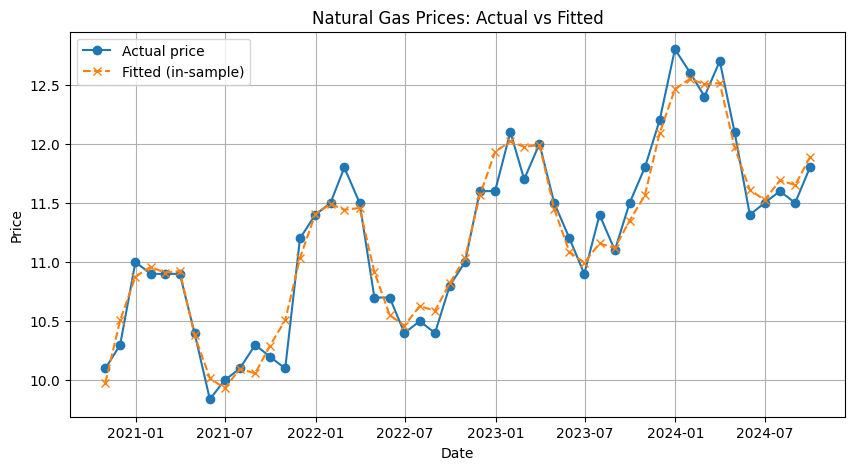

In [12]:
import matplotlib.pyplot as plt

# Plot actual vs fitted
plt.figure(figsize=(10,5))
plt.plot(df["date"], y, marker="o", label="Actual price")
plt.plot(df["date"], fitted, linestyle="--", marker="x", label="Fitted (in-sample)")
plt.title("Natural Gas Prices: Actual vs Fitted")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

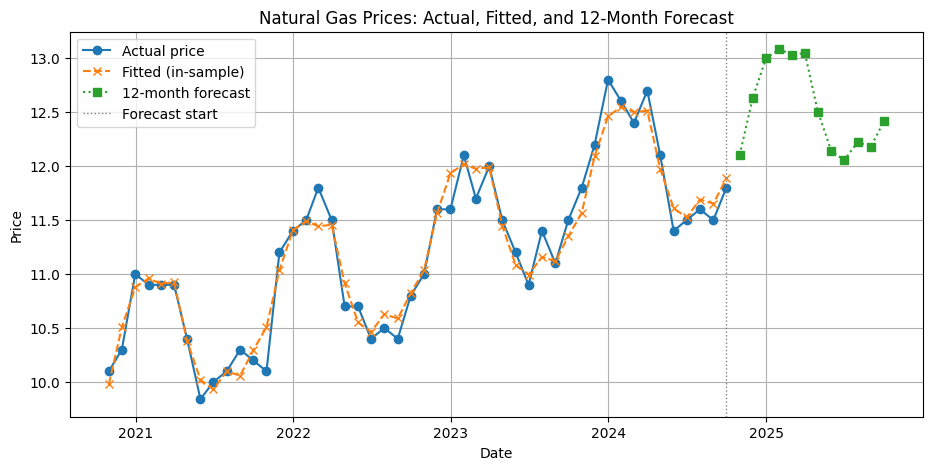


12-month forecast:
         date  predicted_price
0  2024-10-31           12.104
1  2024-11-30           12.631
2  2024-12-31           13.000
3  2025-01-31           13.084
4  2025-02-28           13.034
5  2025-03-31           13.047
6  2025-04-30           12.505
7  2025-05-31           12.143
8  2025-06-30           12.056
9  2025-07-31           12.221
10 2025-08-31           12.182
11 2025-09-30           12.415


In [14]:
# ------------------------
# Forecast 12 months ahead
# ------------------------
last_date = df["date"].max()
future_dates = pd.date_range(
    start=last_date + pd.DateOffset(months=1),
    end=last_date + pd.DateOffset(months=12),
    freq="ME"
)

future_df = pd.DataFrame({"date": future_dates})
future_df["t_days"] = (future_df["date"] - start_date).dt.days
future_df["t_years"] = future_df["t_days"] / 365.25
future_df["sin_year"] = np.sin(2 * np.pi * future_df["t_days"] / 365.25)
future_df["cos_year"] = np.cos(2 * np.pi * future_df["t_days"] / 365.25)
future_df["sin_2y"] = np.sin(4 * np.pi * future_df["t_days"] / 365.25)
future_df["cos_2y"] = np.cos(4 * np.pi * future_df["t_days"] / 365.25)
future_df["month"] = future_df["date"].dt.month.astype(str)

X_future = future_df[numeric_features + categorical_features]
future_df["predicted_price"] = model.predict(X_future)

# ------------------------
# Plot actual, fitted, and forecast
# ------------------------
plt.figure(figsize=(11,5))
plt.plot(df["date"], y, marker="o", label="Actual price")
plt.plot(df["date"], fitted, linestyle="--", marker="x", label="Fitted (in-sample)")
plt.plot(future_df["date"], future_df["predicted_price"], linestyle=":", marker="s", label="12-month forecast")
plt.axvline(last_date, color="grey", linestyle=":", linewidth=1, label="Forecast start")
plt.title("Natural Gas Prices: Actual, Fitted, and 12-Month Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

# ------------------------
# Optional: preview forecasted values
# ------------------------
print("\n12-month forecast:")
print(future_df[["date", "predicted_price"]].round(3))

In [15]:
def estimate_price(query_date):
    """
    Estimate natural gas price for any given date.
    
    Parameters:
        query_date (str or datetime): The date you want a price for.
    
    Returns:
        dict: {date, predicted_price, flag, uncertainty_1sigma, uncertainty_95ci_approx}
    """
    q = pd.to_datetime(query_date)
    if pd.isna(q):
        raise ValueError("Invalid date format. Try YYYY-MM-DD.")

    last_date = df["date"].max()
    max_allowed = last_date + pd.Timedelta(days=365)

    # Flagging
    if q < df["date"].min():
        flag = "before_history"
    elif q > max_allowed:
        flag = "too_far_future"
    elif q > last_date:
        flag = "extrapolated"
    else:
        flag = "in_sample_or_interpolated"

    # Create features for the query date
    t_days = (q - start_date).days
    row = pd.DataFrame({
        "t_years": [t_days / 365.25],
        "sin_year": [np.sin(2 * np.pi * t_days / 365.25)],
        "cos_year": [np.cos(2 * np.pi * t_days / 365.25)],
        "sin_2y": [np.sin(4 * np.pi * t_days / 365.25)],
        "cos_2y": [np.cos(4 * np.pi * t_days / 365.25)],
        "month": [str(q.month)]
    })

    # Predict
    pred = model.predict(row)[0]

    return {
        "date": q.date(),
        "predicted_price": float(pred),
        "flag": flag,
        "uncertainty_1sigma": float(rmse),                # ±1σ error
        "uncertainty_95ci_approx": float(1.96 * rmse)     # ~95% confidence interval
    }

In [19]:
estimate_price("2025-9-11")

{'date': datetime.date(2025, 9, 11),
 'predicted_price': 12.30289902850157,
 'flag': 'extrapolated',
 'uncertainty_1sigma': 0.16202272778212767,
 'uncertainty_95ci_approx': 0.3175645464529702}